In [1]:
class SystemDiffEQ():
    def __init__(self, f_primes: dict, initial_condition: dict):
        self.f_primes = f_primes.copy()
        self.initial_condition = None
        self.f_values = {}
        self.initialize(initial_condition)
    
    def initialize(self, initial_condition: dict):
        self.initial_condition = initial_condition.copy()
        self.f_values[0] = initial_condition.copy()
    
    def generate_value_one_step(self, f_old, dx):
        f_next = {}
        for k in self.f_primes.keys():
            f_next[k] = f_old[k] + self.f_primes[k](f_old) * dx
        return f_next

    def generate_value(self, endpoint, starting_point=0, dx=0.01):
        i = starting_point
        while i < endpoint:
            f_next = self.generate_value_one_step(self.f_values[i], dx)
            self.f_values[i + dx] = f_next.copy()
            i += dx
        
    def get(self, f, value):
        return self.f_values[value][f]

    def get_ts(self):
        return list(self.f_values.keys())

In [2]:
import numpy as np

class Polynomial:
    def __init__(self, coef: list):
        self._coef = coef

    @property
    def degree(self):
        return len(self._coef) - 1

    def coef(self, deg):
        if deg > self.degree:
            return 0
        return self._coef[self.degree - deg]

    def diff(self):
        diff_coef = []
        for deg in range(1, self.degree + 1):
            deg_coef = self.coef(deg)
            diff_coef = [deg_coef * deg] + diff_coef
        return Polynomial(diff_coef)

    def antidiff(self, x: float, y: float):
        int_coef = []
        c = y
        for deg in range(self.degree + 1):
            deg_coef = self.coef(deg)
            coef = deg_coef / (deg + 1)
            int_coef = [coef] + int_coef
            c -= coef * (x ** (deg + 1))
        int_coef.append(c)
        return Polynomial(int_coef)
    
    def integrate(self, x_lower: float, x_upper: float):
        intf = self.antidiff(0,0)
        return intf(x_upper) - intf(x_lower)

    def __repr__(self):
        func_str = []
        for deg in reversed(range(self.degree + 1)):
            if self.coef(deg) == 0:
                continue
            if deg == 0:
                func_str.append(f"{self.coef(deg)}")
                continue
            func_str.append(f"{self.coef(deg)}x^{deg}")
        return f"Polynomial({'+'.join(func_str)})"

    def __call__(self, x):
        px = 0
        for deg in range(self.degree + 1):
            px += self.coef(deg) * (x ** deg)
        return px

    def __add__(self, other):
        new_coef = [0] * max(self.degree + 1, other.degree + 1)
        for deg in range(len(new_coef)):
            new_coef[- deg - 1] = self.coef(deg) + other.coef(deg)
        return Polynomial(new_coef)

    def __sub__(self, other):
        new_coef = [0] * max(self.degree + 1, other.degree + 1)
        for deg in range(len(new_coef)):
            new_coef[-deg - 1] = self.coef(deg) - other.coef(deg)
        return Polynomial(new_coef)

    def __mul__(self, other):
        new_coef = [0] * (self.degree + other.degree + 1)
        for deg1 in range(self.degree + 1):
            for deg2 in range(other.degree + 1):
                new_coef[-deg1 - deg2 - 1] += self.coef(deg1) * other.coef(deg2)
        return Polynomial(new_coef)

    def __pow__(self, n):
        if n == 0:
            return Polynomial([1])
        if n == 1:
            return self
        result = self
        for i in range(n - 1):
            result *= self
        return result

class CubicSpline:
    def __init__(self, xy):
        self._xy = sorted(xy, key=lambda x: x[0])

    def solve_second_diff(self):
        second_diff = [0]
        mat = []
        for i in range(1, len(self._xy) - 1):
            x1, y1 = self._xy[i-1]
            xmid, ymid = self._xy[i]
            x2, y2 = self._xy[i+1]
            d1 = (ymid - y1) / (xmid - x1)
            d2 = (y2 - ymid) / (x2 - xmid)
            second_diff.append(d2 - d1)
        second_diff.append(0)
        for i in range(len(self._xy)):
            mat.append([0 for _ in range(len(self._xy))])
            if i in [0, len(self._xy) - 1]:
                mat[-1][i] = 1
                continue
            x1, y1 = self._xy[i-1]
            xmid, ymid = self._xy[i]
            x2, y2 = self._xy[i+1]
            mat[-1][i-1] = (xmid - x1) / 6
            mat[-1][i] = (x2 - x1) / 3
            mat[-1][i+1] = (x2 - xmid) / 6
        return np.linalg.solve(mat, second_diff)

    def fit(self):
        self.poly = {}
        M = self.solve_second_diff()
        for i in range(len(self._xy) - 1):
            x0, y0 = self._xy[i]
            x1, y1 = self._xy[i+1]
            dds = Polynomial([(M[i+1] - M[i]) / (x1 - x0), M[i] - (M[i+1] - M[i]) / (x1 - x0) * x0])
            s0 = dds.antidiff(0,0).antidiff(0,0)
            c, d = np.linalg.solve([[x0, 1], [x1, 1]], [y0 - s0(x0), y1 - s0(x1)])
            s0._coef[-2] = c
            s0._coef[-1] = d
            self.poly[(x0, x1)] = s0
        return self.poly
    
    def _predict(self, x):
        for (x0, x1), polynom in self.poly.items():
            if x0 <= x and x <= x1:
                return polynom(x)

    def predict(self, x):
        if self._xy[0][0] <= x <= self._xy[-1][0]:
            return self._predict(x)
        raise ValueError(f"{x} is not feasible for the spline, it needs to be between {self._xy[0][0]} and {self._xy[-1][0]}")

In [3]:
def create_SIR_model(infection_rate, recovery_rate, initial_infection):
    def S_prime(params):
        return -infection_rate * params['s'] * params['i']

    def I_prime(params):
        return infection_rate * params['s'] * params['i'] - recovery_rate * params['i']

    def R_prime(params):
        return recovery_rate * params['i']

    SIR_Prime = {
        's': S_prime,
        'i': I_prime,
        'r': R_prime
    }

    iC = {
        's': 1 - initial_infection,
        'i': initial_infection,
        'r': 0
    }

    SIR = SystemDiffEQ(SIR_Prime, iC)
    return SIR

In [4]:
initial_infection = 0.1
infection_rate = 0.2
recovery_rate = 0.3
t = 100

In [5]:
SIR_Model = create_SIR_model(infection_rate, recovery_rate, initial_infection)

In [6]:
SIR_Model.generate_value(t, dx=1)

In [7]:
import pandas as pd

solutions = pd.DataFrame(SIR_Model.f_values).T

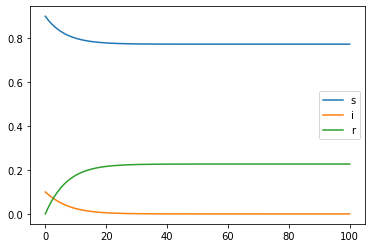

In [8]:
import matplotlib.pyplot as plt

solutions.plot()
plt.show()

In [9]:
susceptible = list(zip(range(0, t+1), solutions.s))
infected = list(zip(range(0, t+1), solutions.i))
recovered = list(zip(range(0, t+1), solutions.r))

In [10]:
susceptible_spline = CubicSpline(susceptible)
infected_spline = CubicSpline(infected)
recovered_spline = CubicSpline(recovered)

In [11]:
susceptible_spline.fit()
infected_spline.fit()
recovered_spline.fit()
print("Fitting Successful")

Fitting Successful


In [12]:
def predict(t):
    return {
        'susceptible': susceptible_spline.predict(t),
        'infected': infected_spline.predict(t),
        'recovered': recovered_spline.predict(t)
    }

In [13]:
predict(7.27)

{'susceptible': 0.8142401921384368,
 'infected': 0.03666167659737475,
 'recovered': 0.1490981312641884}

In [14]:
susceptible_spline.poly[(44,45)]

Polynomial(-7.745584875647429e-08x^3+1.1822200404627534e-05x^2+-0.0006108710650045035x^1+0.7836191836081274)

---